In [1]:
# Importazione delle librerie
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit
import mplhep as hep
from cycler import cycler
import matplotlib.colors as colors
import multiprocessing.pool
from scipy.optimize import approx_fprime
import pandas as pd

In [2]:
# Definizione delle funzioni
C = 1.09*10**-9
sC = 0.08*10**-9

def retta(x, a, b):
    return a + b*x

def fit_Tf_R(x, Q, ft, B):
    return B/np.sqrt(1+Q**2*((ft/x)**2-(x/ft)**2)**2)

def fit_phi_R(x, Q, ft):
    return np.arctan(-Q*(ft/x-x/ft))

def fit_Tf_C(x, Q, ft, A):
    return A/np.sqrt((1-(x/ft)**2)**2+(x/(ft*Q))**2)

def fit_phi_C(x, Q, ft):
    # return np.arctan(Q*(ft/x-x/ft)) + a
    return np.arctan(1/Q * 1/(ft/x-x/ft))

def fit_phi_c(x, Q, ft, a):
    return np.arctan(-Q*(ft/x-x/ft)) + a
    # return np.arctan(1/Q * 1/(ft/x-x/ft))

def Tf_R(x, L, R, B):
    return B*x/np.sqrt(x**4-2*x**2*(1/(L*C)-R**2/(2*L**2))+1/(L*C)**2)

def phi_R(x,L,R):
    return np.arctan(R/(1/(x*C)-x*L))

def A_C(x, L, R, A):
    return A/(np.sqrt(x**4-2*x**2*(1/(L*C)-R**2/(2*L**2))+1/(L*C)**2)*L*C)

def phi_C(x,L,R):
    return np.arctan((1/(x*C)-x*L)/R)

In [3]:
# Impostazioni grafici
plt.style.use(hep.style.ROOT)
params = {'legend.fontsize': '12',
         'legend.loc': 'upper right',
          'legend.frameon':       'True',
          'legend.framealpha':    '0.8',      # legend patch transparency
          'legend.facecolor':     'w', # inherit from axes.facecolor; or color spec
          'legend.edgecolor':     'w',      # background patch boundary color
          'figure.figsize': (6, 4),
         'axes.labelsize': '12',
         'figure.titlesize' : '16',
         'axes.titlesize':'14',
         'xtick.labelsize':'12',
         'ytick.labelsize':'12',
         'lines.linewidth': '1',
         'text.usetex': True,
#         'axes.formatter.limits': '-5, -3',
         'axes.formatter.min_exponent': '2',
#         'axes.prop_cycle': cycler('color', 'bgrcmyk')
         'figure.subplot.left':'0.125',
         'figure.subplot.bottom':'0.125',
         'figure.subplot.right':'0.925',
         'figure.subplot.top':'0.925',
         'figure.subplot.wspace':'0.1',
         'figure.subplot.hspace':'0.1',
#         'figure.constrained_layout.use' : True
          }
plt.rcParams.update(params)
plt.rcParams['axes.prop_cycle'] = cycler(color=['b','g','r','c','m','y','k'])

In [4]:
# Importazione dei dati per fit globale
data = pd.read_csv('Dati R.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

f = data["f"]
phi = 2e-6 * np.pi * data["f"] * data["dT"] # in rapporto a 90°
sphi = 2e-6 * np.pi * data["f"] * np.sqrt(data["sT"]/(10*12**0.5))

sVin = np.sqrt((0.03*data["Ach1"]/(24**0.5))**2+(data["Sch1"]/(25*24**0.5))) # Assumo triangolare

Tf = data["Ach2"]/data["Ach1"]
sTf = np.sqrt((0.03*data["Ach2"]/(12**0.5))**2+(data["Sch2"]/(25*12**0.5)) + (data["Ach2"]/data["Ach1"] * sVin)**2)/data["Ach1"] # Assumo uniforme

frequenze = []
sfrequenze = []
qvalore = []
sqvalore = []
covfq = []
resistenze = []
sresistenze = []
impedenze = []
simpedenze = []

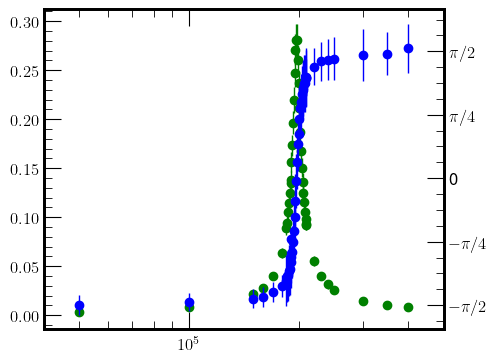

In [5]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(f, Tf, yerr=sTf , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.set_yticks((-np.pi/2,-np.pi/4,0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels((r'$-\pi / 2$',r'$-\pi / 4$','0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi, xerr=sphi , fmt='bo')

axA.set_xlim(min(f)-1e4,max(f)+10**5)

plt.show()

[1.15639689e+01 1.97316314e+05 2.80296440e-01] [[ 1.82287812e-01  1.42502632e-01  2.70525769e-03]
 [ 1.42502632e-01  1.56838171e+04 -8.79724483e-03]
 [ 2.70525769e-03 -8.79724483e-03  5.00350145e-05]]
0.07063947956350546


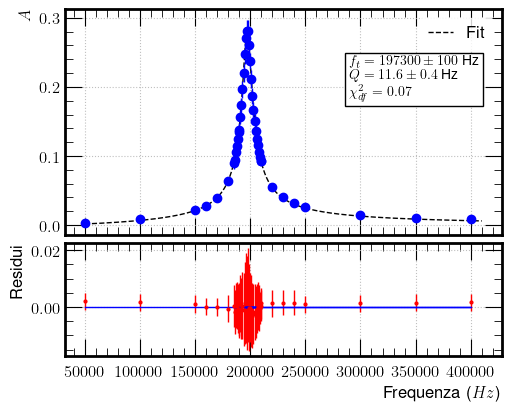

In [6]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_R, f, Tf, p0=[36, 196850, 0.3], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr)

resTr = Tf - fit_Tf_R(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-1))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))
qvalore.append(valtr[0])
sqvalore.append(np.sqrt(covtr[0,0]))
covfq.append(covtr[0,1])


# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_R(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2Tf/(len(f)-2))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

[1.95766874e+01 1.96807850e+05] [[4.34788834e+00 7.63648451e+01]
 [7.63648451e+01 2.06863938e+05]]
7.744803459538439e-05


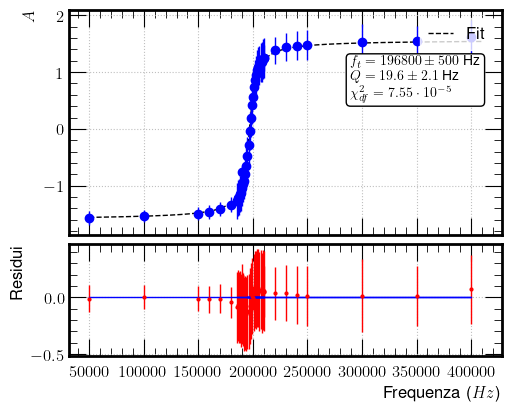

In [7]:
# Fit della funzione di trasferimento non lineare
valphi, covphi = curve_fit(fit_phi_R, f, phi, p0=[36, 196850], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi)

resphi = phi - fit_phi_R(f, *valphi)
chi2phi = np.sum((resTr/sphi)**2)
print(chi2phi/(len(f)-2))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

frequenze.append(valphi[1])
sfrequenze.append(np.sqrt(covphi[1,1]))
qvalore.append(valphi[0])
sqvalore.append(np.sqrt(covphi[0,0]))
covfq.append(covphi[0,1])

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_R(x_fit, *valphi), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, phi, yerr=sphi , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valphi[1],-2), round(np.sqrt(covphi[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valphi[0], np.sqrt(covphi[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phi/(len(f)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resphi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

C:\Users\metru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\metru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\metru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\metru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pandas\core\arraylike.py:399: RuntimeWarning:

[9.99660267e-04 9.83873807e+03 5.49649256e+05] [[ 1.37546544e+02  1.28359008e+07 -7.58989656e+10]
 [ 1.28359008e+07  1.19785311e+12 -7.08292302e+15]
 [-7.58989656e+10 -7.08292302e+15  4.18814810e+19]]
109.41692091266668


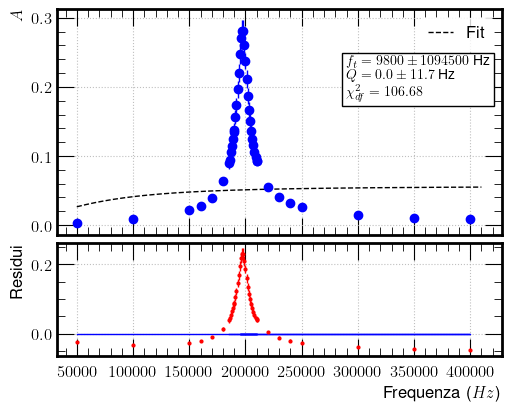

In [8]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(Tf_R, f, Tf, p0=[0.558*10**-3, 20, 0.3], method='lm' ,sigma=sTf, absolute_sigma=True)
print(valtr, covtr)

resTr = Tf - Tf_R(f, *valtr)
chi2Tf = np.sum((resTr/sTf)**2)
print(chi2Tf/(len(f)-2))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

impedenze.append(valtr[1])
simpedenze.append(np.sqrt(covtr[1,1]))
resistenze.append(valtr[0])
sresistenze.append(np.sqrt(covtr[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, Tf_R(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, Tf, yerr=sTf , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2Tf/(len(f)-1))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='square', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resTr,yerr=sTf, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

[5.73394401e-03 2.88650960e+01] [[ 4.74779524e-10 -3.89038403e-06]
 [-3.89038403e-06  9.87817879e+03]]
0.20417399345937154


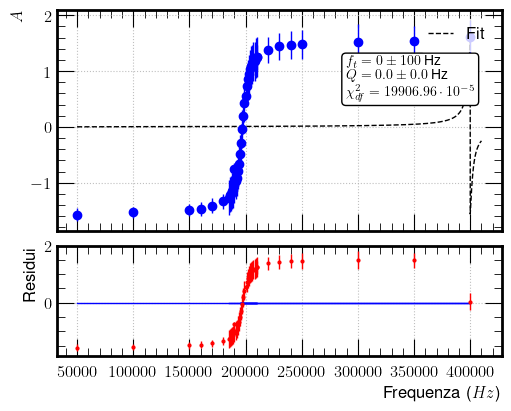

In [9]:
# Fit della funzione di trasferimento non lineare
valphi, covphi = curve_fit(phi_R, f, phi, p0=[0.558*10**-3, 20], method='lm' ,sigma=sphi, absolute_sigma=True)
print(valphi, covphi)

resphi = phi - phi_R(f, *valphi)
chi2phi = np.sum((resTr/sphi)**2)
print(chi2phi/(len(f)-2))

x_fit = np.linspace(min(f)-100,max(f)+1e4, 10000)

impedenze.append(valphi[1])
simpedenze.append(np.sqrt(covphi[1,1]))
resistenze.append(valphi[0])
sresistenze.append(np.sqrt(covphi[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, phi_R(x_fit, *valphi), label='Fit', linestyle='--', color='black')
ax[0].errorbar(f, phi, yerr=sphi , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valphi[1],-2), round(np.sqrt(covphi[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valphi[0], np.sqrt(covphi[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phi/(len(f)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(f,resphi,yerr=sphi, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(f,np.zeros(len(f)))
ax[1].grid(True)

In [10]:
# Importazione dei dati per fit globale
dataC = pd.read_csv('Dati C.txt', sep="\t")

# I file devono essere formattati in questo modo:
# f	Vch2	sV	dT	sT
# con f [Hz], Vch2[V], sV[V], dT[us], sT[us]:
# - f, frequenze in ingresso [Hz]
# - Vch2, Ampiezza misurata ai capi della resistenza [V]
# - sV, scala della misura dell'ampiezza [V]
# - dT, differenza temporale fra 2 intersezioni con lo 0 V [us]
# - sT, scala della misura dei tempi [us]

fC = dataC["f"]
phiC = 2e-9 * np.pi * dataC["f"] * dataC["dT"] # in rapporto a 90°
sphiC = 2e-6 * np.pi * dataC["f"] * np.sqrt(dataC["sT"]/(10*12**0.5))

sVin = np.sqrt((0.03*dataC["Ach1"]/(24**0.5))**2+(dataC["Sch1"]/(25*24**0.5))) # Assumo triangolare

TfC = dataC["Ach2"]/dataC["Ach1"]
sTfC = np.sqrt((0.03*dataC["Ach2"]/(12**0.5))**2+(dataC["Sch2"]/(25*12**0.5)) + (dataC["Ach2"]/dataC["Ach1"] * sVin)**2)/dataC["Ach1"] # Assumo uniforme

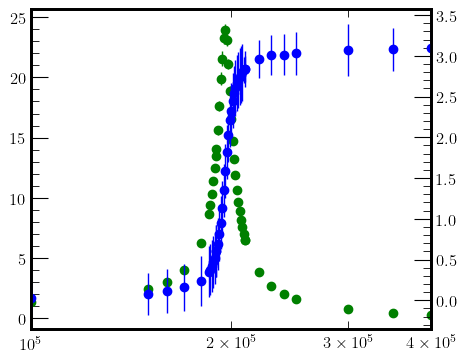

In [11]:
# Plot dei dati importati
fig, axA = plt.subplots(1,1, figsize=(5,4))
axA.errorbar(fC, TfC, yerr=sTfC , fmt='go')
axA.semilogx()
axF = axA.twinx()

axF.errorbar(fC, phiC,  yerr= sphiC, fmt='bo')

axA.set_xlim(min(fC),max(fC))

plt.show()

[2.35801335e+01 1.95961150e+05 1.01010516e+00] [[ 8.04253805e-02  3.10934944e-01 -8.93167963e-04]
 [ 3.10934944e-01  1.82428194e+03 -3.00714915e-02]
 [-8.93167963e-04 -3.00714915e-02  2.21475903e-05]]
0.11386972278221485


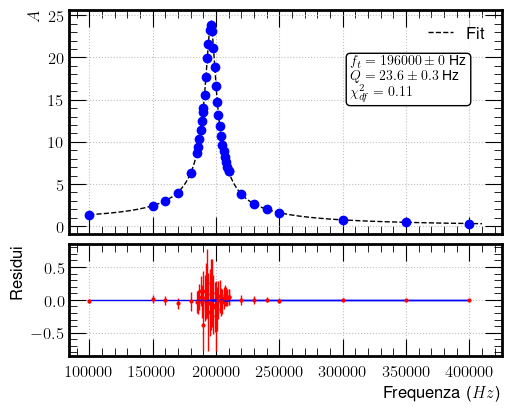

In [12]:
# Fit della funzione di trasferimento non lineare
valtr, covtr = curve_fit(fit_Tf_C, fC, TfC, p0=[11.6, 197300, 1], method='lm' ,sigma=sTfC, absolute_sigma=True)
print(valtr, covtr)

resTr = TfC - fit_Tf_C(fC, *valtr)
chi2TfC = np.sum((resTr/sTfC)**2)
print(chi2TfC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valtr[1])
sfrequenze.append(np.sqrt(covtr[1,1]))
qvalore.append(valtr[0])
sqvalore.append(np.sqrt(covtr[0,0]))
covfq.append(covtr[0,1])


# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_Tf_C(x_fit, *valtr), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, TfC, yerr=sTfC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$A$')

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f$' % (chi2TfC/(len(fC)-1))))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)

ax[1].errorbar(fC,resTr,yerr=sTfC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

[ 1.36368137e-06 -1.83637364e+05] [[ 5.77739286e-03 -7.17515503e+07]
 [-7.17515503e+07  8.78901687e+18]]
21.304788729559558


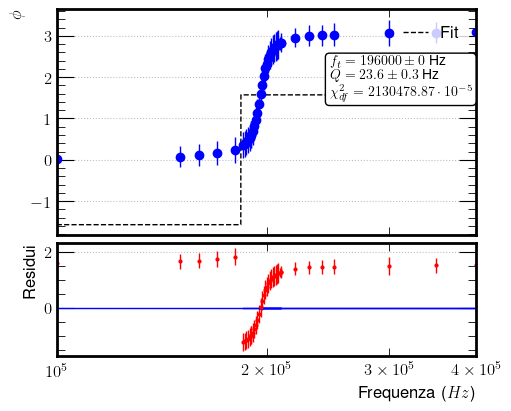

In [13]:
# Fit della funzione di trasferimento non lineare
valphiC, covphiC = curve_fit(fit_phi_C, fC, phiC, p0=[11, 196850], method='lm' ,sigma=sphiC, absolute_sigma=True)
print(valphiC, covphiC)

resphiC = phiC - fit_phi_C(fC, *valphiC)
chi2phiC = np.sum((resphiC/sphiC)**2)
print(chi2phiC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

# frequenze.append(valphiC[1])
# sfrequenze.append(np.sqrt(covphiC[1,1]))

# qvalore.append(valphiC[0])
# sqvalore.append(np.sqrt(covphiC[0,0]))

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_C(x_fit, *valphiC), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, phiC, yerr=sphiC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$\phi$')
ax[0].semilogx()
ax[0].set_xlim(min(fC)-10, max(fC)+10)

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phiC/(len(fC)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(fC,resphiC,yerr=sphiC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

[2.35806052e+01 1.95884214e+05 1.56320153e+00] [[ 1.20596247e+01 -2.55076345e+02 -3.63868238e-02]
 [-2.55076345e+02  4.56011126e+05  2.31601674e+01]
 [-3.63868238e-02  2.31601674e+01  3.12364805e-03]]
0.0010190528062560451


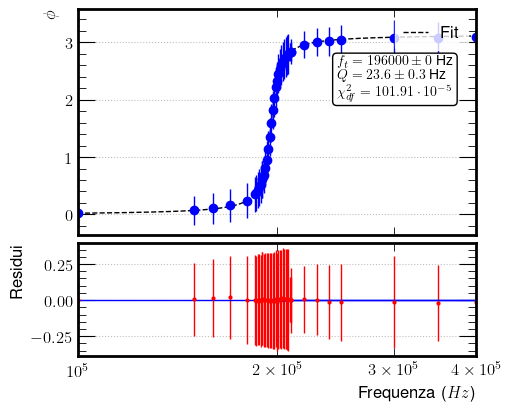

In [14]:
# Fit della funzione di trasferimento non lineare
valphiC, covphiC = curve_fit(fit_phi_c, fC, phiC, p0=[11, 196850, np.pi/2], method='lm' ,sigma=sphiC, absolute_sigma=True)
print(valphiC, covphiC)

resphiC = phiC - fit_phi_c(fC, *valphiC)
chi2phiC = np.sum((resphiC/sphiC)**2)
print(chi2phiC/(len(fC)-1))

x_fit = np.linspace(min(fC)-100,max(fC)+1e4, 10000)

frequenze.append(valphiC[1])
sfrequenze.append(np.sqrt(covphiC[1,1]))
qvalore.append(valphiC[0])
sqvalore.append(np.sqrt(covphiC[0,0]))
covfq.append(covphiC[0,1])

# Plot the first fit to define t0
fig, ax = plt.subplots(2, 1, figsize=(5, 4),sharex=True, constrained_layout = True, height_ratios=[2, 1])
ax[0].plot(x_fit, fit_phi_c(x_fit, *valphiC), label='Fit', linestyle='--', color='black')
ax[0].errorbar(fC, phiC, yerr=sphiC , fmt='o')
ax[0].legend(loc='upper right')
ax[0].set_ylabel(r'$\phi$')
ax[0].semilogx()
ax[0].set_xlim(min(fC)-10, max(fC)+10)

textstr = '\n'.join((
    r'$f_t = %.f \pm %.f$ Hz' % (round(valtr[1],-2), round(np.sqrt(covtr[1,1]),-2)),
    r'$Q = %.1f \pm %.1f$ Hz' % (valtr[0], np.sqrt(covtr[0,0])),
    r'$\chi^2_{df} = %.2f \cdot 10^{-5}$' % (chi2phiC/(len(fC)-1) *10**5)))

# Posizionamento del box nell'angolo in alto a sinistra
props = dict(boxstyle='round', facecolor='white', alpha=1)
ax[0].text(0.65, 0.8, textstr, transform=ax[0].transAxes, fontsize=10,
           verticalalignment='top', bbox=props)
ax[0].grid(True)


ax[1].errorbar(fC,resphiC,yerr=sphiC, fmt='o', label='Residui',ms=2,color='red')
ax[1].set_ylabel('Residui')
ax[1].set_xlabel(r'Frequenza ($Hz$)')
ax[1].plot(fC,np.zeros(len(fC)))
ax[1].grid(True)

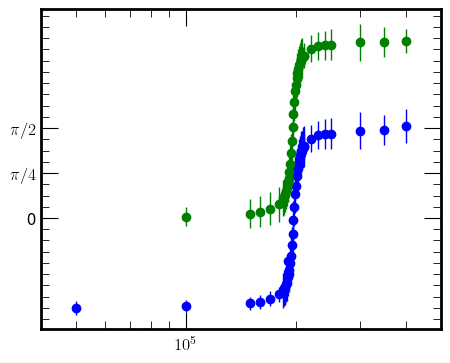

In [15]:
# Plot dei dati importati
fig, axF = plt.subplots(1,1, figsize=(5,4))
axF.semilogx()

axF.set_yticks((0, np.pi/4, np.pi/2))
labels = axF.set_yticklabels(('0', r'$\pi / 4$', r'$\pi / 2$'))

axF.errorbar(f, phi,  yerr= sphi , fmt='bo')
axF.errorbar(fC, phiC,  yerr= sphiC, fmt='go')

axF.set_xlim(min(f)-1e4,max(f)+10**5)

plt.show()

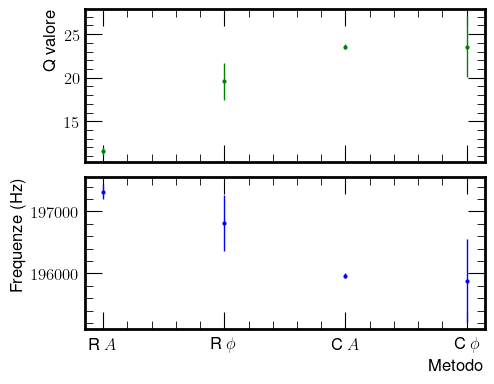

In [16]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], qvalore,  yerr= sqvalore , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], frequenze,  yerr= sfrequenze , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"R $\phi$", r"C $A$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("Q valore")
ax[1].set_ylabel("Frequenze (Hz)")

plt.show()

In [17]:
# Stime di R e L con C fisso
C = 1.09*10**-9
sC = 0.08*10**-9

f = np.array(frequenze)
sf = np.array(sfrequenze)
q = np.array(qvalore)
sq = np.array(sqvalore)
cov = np.array(covfq)

L = 1/(f**2*C*4*np.pi**2)
sL = L * np.sqrt((sf/f)**2+(sC/C)**2)

R = 1/(f*q*C*2*np.pi)
sR = R * np.sqrt((sf/f)**2 + (sC/C)**2 + (sq/q)**2 + 2 * cov/(q*f))

for i in range(4):
    print("L: ", L[i], "+/-", sL[i])
for i in range(4):
    print("R: ", R[i], "+/-", sR[i])

L:  0.0005968810297507194 +/- 4.3809419992716115e-05
L:  0.0005999691655568402 +/- 4.4056257839707484e-05
L:  0.0006051650046929141 +/- 4.441597601445907e-05
L:  0.0006056404730110112 +/- 4.449968397595048e-05
R:  63.991711295136696 +/- 5.257623092819761
R:  37.8976264373625 +/- 4.9086738954854745
R:  31.59929501731985 +/- 2.3501842854389765
R:  31.611073812277287 +/- 5.191959926367486


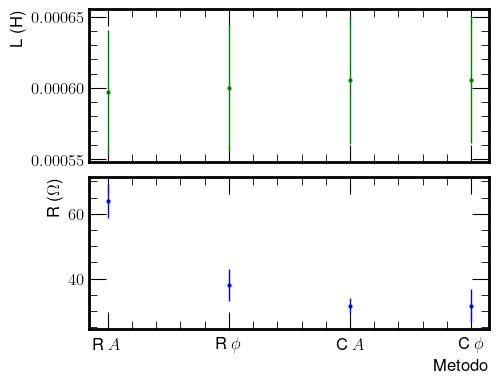

In [18]:
fig, ax = plt.subplots(2,1, figsize=(5,4), sharex = True)

ax[0].errorbar([0,1,2,3], L,  yerr= sL , fmt='go', ms = 2)

ax[1].errorbar([0,1,2,3], R,  yerr= sR , fmt='bo', ms = 2)


ax[1].set_xticks([0,1,2,3])
labels = ax[1].set_xticklabels((r"R $A$", r"R $\phi$", r"C $A$", r"C $\phi$"))

ax[1].set_xlabel("Metodo")
ax[0].set_ylabel("L (H)")
ax[1].set_ylabel(r"R ($\Omega$)")

plt.show()